#### Câu hỏi: Phân loại hàng hóa vào dựa vào lượt bán
#### Khi trả lời câu hỏi này: 
- Phân loại sản phẩm thành các nhóm "Best Seller" và "Low Seller" giúp bạn tập trung vào các sản phẩm bán chạy, từ đó tối ưu hóa các chiến lược marketing, giảm giá hoặc khuyến mãi cho các sản phẩm ít bán
- Việc phân loại sản phẩm giúp bạn xác định sản phẩm nào cần duy trì trong kho và sản phẩm nào cần đẩy mạnh quảng bá hoặc giảm giá. Những sản phẩm "Best Seller" có thể được dự trữ nhiều hơn, trong khi những sản phẩm "Low Seller" có thể cần thay đổi chiến lược hoặc giảm giá.
#### Thực hiện:

In [24]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


In [3]:
# Load data
file_path = '../data/processed/normalization.csv'  # Đường dẫn đến file dữ liệu của bạn
data = pd.read_csv(file_path)

data.info(), data.head(), data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452 entries, 0 to 1451
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_name   1452 non-null   object 
 1   rating         1452 non-null   float64
 2   comment_count  1452 non-null   float64
 3   price          1452 non-null   float64
 4   sold           1452 non-null   float64
dtypes: float64(4), object(1)
memory usage: 56.8+ KB


(None,
                                         product_name  rating  comment_count  \
 0  [HCM]Thẻ nhớ 64gb, Thẻ nhớ camera YOOSEE Micro...     0.0       0.000000   
 1  [HCM]Thẻ nhớ 32gb, Thẻ nhớ camera YOOSEE Micro...     0.0       0.000000   
 2  Thẻ nhớ TF 16GB 32GB 64GB 128GB 256GB 512GB 1T...     0.0       0.000000   
 3  Thẻ Nhớ Kioxia 32GB và Thẻ Nhớ Sandisk (64GB/1...     5.0       0.057169   
 4  Thẻ Nhớ 32 gb ( Thẻ nhớ dành chuyên cho camera...     0.0       0.000000   
 
       price      sold  
 0  0.004536  0.005231  
 1  0.003530  0.033705  
 2  0.002621  0.004938  
 3  0.008507  0.024823  
 4  0.001337  0.000808  ,
 Index(['product_name', 'rating', 'comment_count', 'price', 'sold'], dtype='object'))

In [4]:
# Phân tích tương quan giữa comment_count và sold
correlation = data['comment_count'].corr(data['sold'])
print(f"Hệ số tương quan giữa số lượng bình luận và số lượng bán: {correlation:.4f}")

Hệ số tương quan giữa số lượng bình luận và số lượng bán: 0.5170


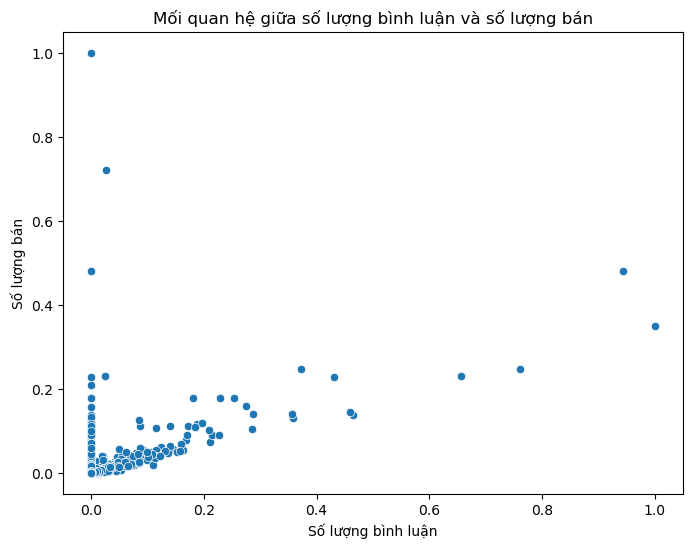

In [5]:
# Vẽ biểu đồ phân tán giữa comment_count và sold
plt.figure(figsize=(8, 6))
sns.scatterplot(x='comment_count', y='sold', data=data)
plt.title('Mối quan hệ giữa số lượng bình luận và số lượng bán')
plt.xlabel('Số lượng bình luận')
plt.ylabel('Số lượng bán')
plt.show()

In [7]:
# Load training and test data

train_file_path = '../data/processed/train_data.csv'  
test_file_path = '../data/processed/test_data.csv'    

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

In [8]:
# Check data
print(train_data.head())
print(test_data.head())

                                        product_name  rating  comment_count  \
0             Laptop giá rẻ phục vụ online, giải trí     4.7       0.010290   
1  Bàn Chải Điện Làm Trắng Răng Halio Sonic White...     4.9       0.047412   
2  Sạc nhanh 120W, Củ sạc + Cáp sạc nhanh USB to ...     4.9       0.020123   
3  Robot hút bụi cao cấp Sweepin,Máy Hút Bụi Tự Đ...     4.9       0.003659   
4  Củ sạc Sạc nhanh 33W OPPO / Củ cáp sạc nhanh O...     4.9       0.003201   

      price      sold  
0  0.090962  0.002309  
1  0.041828  0.026600  
2  0.003156  0.007514  
3  0.013108  0.000586  
4  0.001872  0.001163  
                                        product_name  rating  comment_count  \
0            [QT KHÔNG BÁN] Máy đo huyết áp Glucerna     5.0       0.000457   
1  XiaoZhubangchu Máy Lọc Không Khí Máy Khử Trùng...     0.0       0.000000   
2  Máy chơi game cầm tay Ps5, Bluetooth v5.1, Pin...     0.0       0.000000   
3  【Miễn phí vận chuyển】Đèn học để bàn, Đèn bàn h...     4.8     

In [21]:
# Xác định nhóm phân loại: "Sản phẩm bán chạy" và "Sản phẩm ít bán"
train_data['category'] = np.where(train_data['sold'] > 0.01, 'Best Seller', 'Low Seller')
test_data['category'] = np.where(test_data['sold'] > 0.01, 'Best Seller', 'Low Seller')

# Chọn các đặc trưng (features) và mục tiêu (target)
X_train = train_data[['rating', 'comment_count']]  # Các đặc trưng
y_train = train_data['category']  # Mục tiêu: Danh mục sản phẩm (Best Seller hoặc Low Seller)

X_test = test_data[['rating', 'comment_count']]  # Các đặc trưng cho test
y_test = test_data['category']  # Mục tiêu: Danh mục sản phẩm cho test

In [25]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Convert training labels
y_test = label_encoder.transform(y_test) 

In [26]:
# Khởi tạo các mô hình học máy
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": xgb.XGBClassifier()
}

In [27]:
# Các siêu tham số cần tinh chỉnh
param_grids = {
    "KNN": {'n_neighbors': [3, 5, 7, 10]},
    "Decision Tree": {'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10]},
    "AdaBoost": {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5]},
    "XGBoost": {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5], 'max_depth': [3, 5, 7]}
}

Training model: KNN
Training model: Decision Tree
Training model: AdaBoost


c:\Users\luong\miniconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\luong\miniconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\luong\miniconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\luong\miniconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users

Training model: XGBoost

Model: KNN
Best Parameters: {'n_neighbors': 5}
Accuracy: 0.8509
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.41      0.56       100
           1       0.85      0.98      0.91       336

    accuracy                           0.85       436
   macro avg       0.86      0.70      0.73       436
weighted avg       0.85      0.85      0.83       436



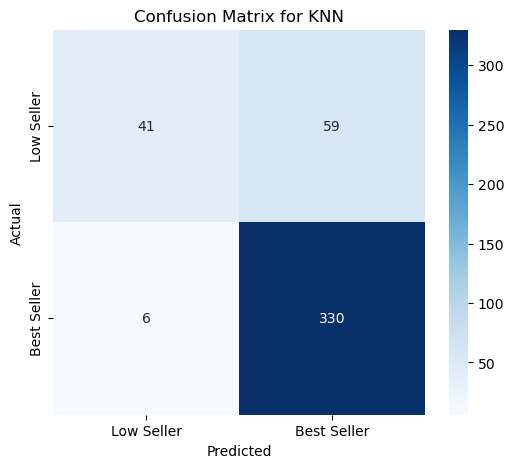


Model: Decision Tree
Best Parameters: {'max_depth': 10, 'min_samples_split': 10}
Accuracy: 0.8417
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.41      0.54       100
           1       0.85      0.97      0.90       336

    accuracy                           0.84       436
   macro avg       0.83      0.69      0.72       436
weighted avg       0.84      0.84      0.82       436



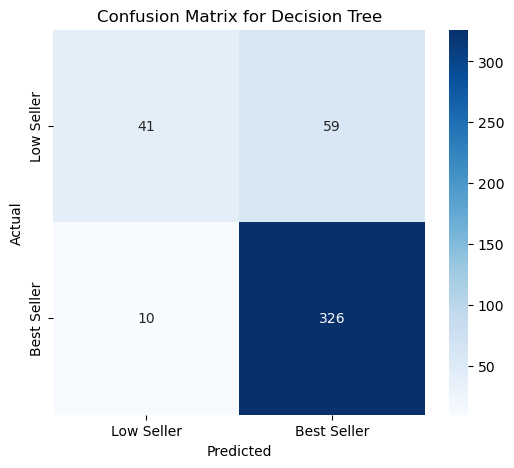


Model: AdaBoost
Best Parameters: {'learning_rate': 0.01, 'n_estimators': 200}
Accuracy: 0.8624
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.42      0.58       100
           1       0.85      0.99      0.92       336

    accuracy                           0.86       436
   macro avg       0.90      0.71      0.75       436
weighted avg       0.88      0.86      0.84       436



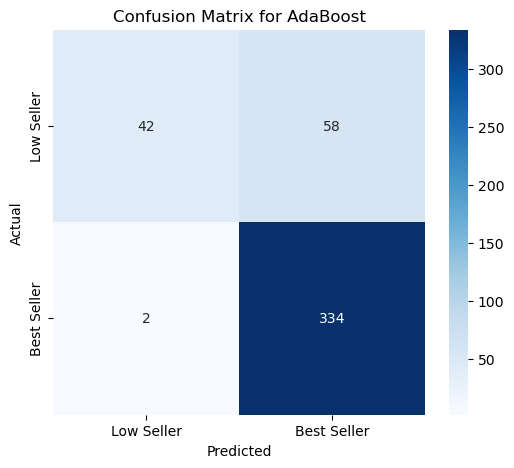


Model: XGBoost
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.8555
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.42      0.57       100
           1       0.85      0.99      0.91       336

    accuracy                           0.86       436
   macro avg       0.87      0.70      0.74       436
weighted avg       0.86      0.86      0.83       436



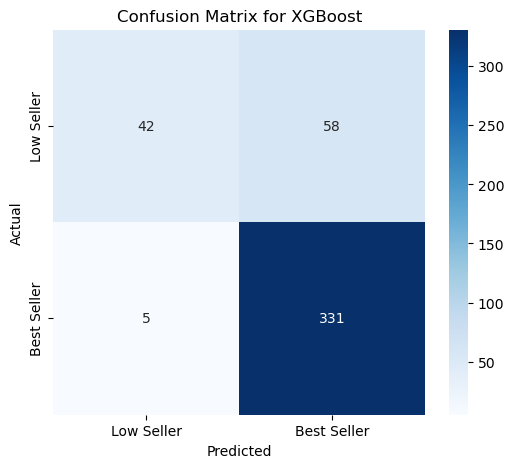

In [28]:
# Tinh chỉnh siêu tham số với GridSearchCV và cross-validation
# Tinh chỉnh siêu tham số với GridSearchCV và cross-validation
results = {}
for model_name, model in models.items():
    print(f"Training model: {model_name}")
    param_grid = param_grids[model_name]
    
    # Tinh chỉnh siêu tham số với GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Lấy mô hình tối ưu
    best_model = grid_search.best_estimator_
    
    # Dự đoán danh mục sản phẩm trên tập kiểm tra
    y_pred = best_model.predict(X_test)
    
    # Đánh giá mô hình
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    # Lưu kết quả
    results[model_name] = {
        "Best Parameters": grid_search.best_params_,
        "Accuracy": accuracy,
        "Classification Report": class_report,
        "Confusion Matrix": confusion_mat
    }

# Hiển thị kết quả
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"Best Parameters: {metrics['Best Parameters']}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Classification Report:\n{metrics['Classification Report']}")
    
    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(6, 5))
    sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Low Seller', 'Best Seller'], yticklabels=['Low Seller', 'Best Seller'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

#### Từ những số liệu có được ta có thể thấy được rằng mô hình AdaBoost đang có các số liệu tốt nhất. Đây là mô hình cho ra kết quả phân tích tốt nhất. Mô hình cho ra kết quả khả quan khi nhận được số liệu về việc phân loại sản phẩm thành các loại sản phẩm